In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Modelling using MEANS

This tutorial describes a way biological systems could be modelled using `MEANS` package.

In this example we will consider a simplified version of tumor-supressor protein *p53* system.
This system models three proteins: *p53*, *Mdm2 precursor* and *Mdm2* and their interactions.

A short schematic of this system is provided below:

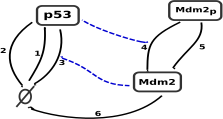

In [2]:
from IPython.display import SVG
SVG('images/p53.svg')

Typically the system is described by the following set of equations:

$$
\begin{aligned}
\text{p53 production} && \emptyset\rightarrow p53 \\
\text{Mdm2 independent p53 degradation} && p53 \rightarrow \emptyset \\
\text{Mdm2 dependent p53 degradation} && Mdm2 + p53 \rightarrow Mdm2 \\
\text{p53 dependent Mdm2 production} && p53 + Mdm2_{precursor} \rightarrow p53 + Mdm2 \\
\text{Mdm2 synthesis from precursor} && Mdm2_{precursor} \rightarrow Mdm2 \\
\text{Mdm2 degradation} && Mdm2 \rightarrow \emptyset \\
\end{aligned}
$$

In this tutorial we alias the protein $p53$, $Mdm2_{precursor}$ and $Mdm2$ names with $y_0$, $y_1$ and $y_2$, respectively. 
We do this purely for notational convenience, to keep the equations light, and is not strictly necessary, as the actual names of proteins can be used in the models directly.

In python, this can be done by building a list of  ``sympy`` symbols with our species names:

In [3]:
import sympy
species = sympy.symbols(['y_0', 'y_1', 'y_2'])
print species

[y_0, y_1, y_2]


From the reactions above, we can directly derive the <a href="http://en.wikipedia.org/wiki/Stoichiometry#Stoichiometry_matrix">stoichiometry matrix</a>:

$$
S = \left( \begin{array}{cccccc}
+1 & -1 & -1 & 0 & 0 & 0\\
0 & 0 & 0 & +1 & -1 & 0\\
0 & 0 & 0 & 0 & +1 & -1 \end{array} \right)
$$

We can use ``numpy`` ``array`` to encode this matrix in python, for example:

In [4]:
import numpy as np
stoichiometry_matrix = np.array([[1, -1, -1, 0, 0, 0],
                                  [0, 0, 0, 1, -1, 0],
                                  [0, 0, 0, 0, 1, -1]])
print stoichiometry_matrix

[[ 1 -1 -1  0  0  0]
 [ 0  0  0  1 -1  0]
 [ 0  0  0  0  1 -1]]


In addition to the stoichiometry matrix, which only gives the net production of species in each reaction, the propensities need to be defined for each reactions. Importantly, **stochastic** propensities (as opposed to deterministic rates) must be provided.

Using this notation, the propensities of the $p53$ model are:
    
$$
\begin{aligned}
a_0 &= c_0 \\
a_1 &= c_1 y_0\\
a_2 &= \frac{c_2 y_2 y_0}{(y_0+c_6)}\\
a_3 &= c_3 y_0\\
a_4 &= c_4 y_1\\
a_5 &= c_5 y_2\\
\end{aligned}
$$

where: 

* $c_0$ is the *p53* production rate,
* $c_1$ is the *Mdm2*-independent *p53* degradation rate,
* $c_2$ is the saturation *p53* degradation rate
* $c_3$ is the *p53*-dependent *Mdm2* production rate,
* $c_4$ is the *Mdm2* maturation rate,
* $c_5$ is the *Mdm2* degradation rate.     
* $c_6$ is the threshold for degradation by *Mdm2*.


In Python, we need to explicitly write down the constant parameters of the model using `sympy` package:

In [5]:
parameters = sympy.symbols(['c_0', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6'])
print parameters

[c_0, c_1, c_2, c_3, c_4, c_5, c_6]


We can now describe the actual propensities as python objects.
To do this, we drop the left-hand-side of equations ($a_0$, ..., $a_5$) and create a python list (or, alternatively, a ``sympy.Matrix``) of the right-hand-sides:

In [6]:
propensities=['c_0',
              'c_1*y_0',
              'c_2*y_2*y_0/(y_0+c_6)',
              'c_3*y_0',
              'c_4*y_1',
              'c_5*y_2']
print propensities

['c_0', 'c_1*y_0', 'c_2*y_2*y_0/(y_0+c_6)', 'c_3*y_0', 'c_4*y_1', 'c_5*y_2']


Note that we just used a list of strings as our propensities above.
In most cases `MEANS` would be able to convert the string representation into an object of the right kind, so one does not need to explicitly worry about that.

The propensities were the final objects we need to describe in order to be able to create a `MEANS` model object.

But before we do so, we need to the `MEANS` package first:

In [7]:
import means

The ``means.Model`` constructor takes the list of species, the list of parameters, the propensities and the stoichiometry matrix in that order.

In [8]:
my_model = means.Model(species, parameters, propensities, stoichiometry_matrix)

The model created should be the same as described earlier:

In [9]:
my_model

<class 'means.core.model.Model'>
Species: [y_0, y_1, y_2]
Parameters: [c_0, c_1, c_2, c_3, c_4, c_5, c_6]

Stoichiometry matrix:
Matrix([
[1, -1, -1, 0,  0,  0],
[0,  0,  0, 1, -1,  0],
[0,  0,  0, 0,  1, -1]])

Propensities:
Matrix([
[                    c_0],
[                c_1*y_0],
[c_2*y_0*y_2/(c_6 + y_0)],
[                c_3*y_0],
[                c_4*y_1],
[                c_5*y_2]])

In addition to the $\LaTeX$ rendering, which is the default in the IPython environment,
pythonic representation of model can be displayed using ``print``.

In [10]:
print my_model

<class 'means.core.model.Model'>
Species: [y_0, y_1, y_2]
Parameters: [c_0, c_1, c_2, c_3, c_4, c_5, c_6]

Stoichiometry matrix:
Matrix([
[1, -1, -1, 0,  0,  0],
[0,  0,  0, 1, -1,  0],
[0,  0,  0, 0,  1, -1]])

Propensities:
Matrix([
[                    c_0],
[                c_1*y_0],
[c_2*y_0*y_2/(c_6 + y_0)],
[                c_3*y_0],
[                c_4*y_1],
[                c_5*y_2]])


The attributes for each of the elements in the model can be accessed directly, but are read-only:

In [11]:
print my_model.species
print my_model.parameters
print my_model.stoichiometry_matrix
print my_model.propensities

[y_0, y_1, y_2]
[c_0, c_1, c_2, c_3, c_4, c_5, c_6]
Matrix([[1, -1, -1, 0, 0, 0], [0, 0, 0, 1, -1, 0], [0, 0, 0, 0, 1, -1]])
Matrix([[c_0], [c_1*y_0], [c_2*y_0*y_2/(c_6 + y_0)], [c_3*y_0], [c_4*y_1], [c_5*y_2]])


## Example Models in Means

`MEANS` already package provides a few sample models:

* `MODEL_DIMERISATION`, 
* `MODEL_MICHAELIS_MENTEN`, 
* `MODEL_P53`
* `MODEL_HES1`,
* `MODEL_LOTKA_VOLTERRA`. 

These models can be accesseed from `examples` submodule. Let's use `MODEL_LOTKA_VOLTERRA` as an example.

In [12]:
from means.examples.sample_models import MODEL_LOTKA_VOLTERRA
print MODEL_LOTKA_VOLTERRA

<class 'means.core.model.Model'>
Species: [Pred, Prey]
Parameters: [k_1, k_2, k_3]

Stoichiometry matrix:
Matrix([
[0,  1, -1],
[1, -1,  0]])

Propensities:
Matrix([
[     Prey*k_1],
[Pred*Prey*k_2],
[     Pred*k_3]])


As noted above, the names of the species may not necessarily be mathematical symbols: $y_0$, $y_1$.
In the Lotka-Volterra model, for instance, we use shortenings of the actual names of the species (*Predator* and *Prey*).

### Reading Models From Files

``MEANS`` models can be saved to file and read from it with the help of ``means.io`` package. 
This package provides methods ``to_file`` and ``from_file`` that can read arbitrary python objects from files,
as long as they were serialised in YAML format.
Similarly, `Model` class itself has a ``to_file()`` and ``from_file()`` methods designed to help you with these tasks.

We took great care of making `Model` objects cleanly serialisable with YAML into human-readable fashion.

Please find a demonstration below:

Let's save `my_model` to file:

In [13]:
my_model.to_file('my_model.model')

Let's print the contents of this newly-created file:

In [14]:
with open('my_model.model') as f:
    print f.read()

!model
species: [y_0, y_1, y_2]
parameters: [c_0, c_1, c_2, c_3, c_4, c_5, c_6]
stoichiometry_matrix:
- [1, -1, -1, 0, 0, 0]
- [0, 0, 0, 1, -1, 0]
- [0, 0, 0, 0, 1, -1]
propensities: [c_0, c_1*y_0, c_2*y_0*y_2/(c_6 + y_0), c_3*y_0, c_4*y_1, c_5*y_2]



One can se how easy to read this serialisation form is.

This form is also machine-readable, and we can indeed read the model object back from this file easily:

In [15]:
my_model_new = means.Model.from_file('my_model.model')
my_model_new

<class 'means.core.model.Model'>
Species: [y_0, y_1, y_2]
Parameters: [c_0, c_1, c_2, c_3, c_4, c_5, c_6]

Stoichiometry matrix:
Matrix([
[1, -1, -1, 0,  0,  0],
[0,  0,  0, 1, -1,  0],
[0,  0,  0, 0,  1, -1]])

Propensities:
Matrix([
[                    c_0],
[                c_1*y_0],
[c_2*y_0*y_2/(c_6 + y_0)],
[                c_3*y_0],
[                c_4*y_1],
[                c_5*y_2]])

Which is the same model we used previously.

Let's delete this file we used to illustrate this:

In [16]:
import os
os.unlink('my_model.model')

#### SBML Support (**requires SBML library installed on your machine**)

More complicated biological models can be parsed from SBML files. 

[Biomodels repository](http://www.ebi.ac.uk/biomodels-main/) hosts a large number of published biological models.


Consider the Tutorial 1a. SBML Parsing Example for more information on how to download SBML models using MEANS.

# Modelling Stochastic Dynamics

Creating models is nice and fun, however, what we are really interested in is the ability to study them.

## Moment Expansion Approximation

In their [2013 paper](http://scitation.aip.org/content/aip/journal/jcp/138/17/10.1063/1.4802475),
Ale *et al.* describe a Moment Expansion Approximation method for studying the moments of stochastic distributions.

This method, shortened as MEA, approximate the solution for chemical master equation by a system of ODEs.
The algorithm performs a set of moment expansions and returns as a set of ODEs,
each one representing the time derivative of all approximated moments (mixed and non-mixed).

Without going into much mathematical detail, the moment expansions are essentially infinite.
In order to make the problem computable, the approximation needs to be stop at some higher order moment, or in other words, needs to be closed at that moment.

Typically, the moments higher than the maximum specified moment are assumed to be equal to a constant scalar value (most often 0).
We call this type of moment closure ``scalar`` in our package. This is where the "approximation" in Moment Expansion Approximation occurs.

Besides the standard assumption of ``scalar`` value for higher order moments,
we could replace them with the expressions derived from specific probability distributions.
Currently our package supports ``normal``, ``log-normal`` and ``gamma`` distributions to close the higher order moments.

The MEA moment closure is implemented by the ``MomentExpansionApproximation`` class in the ``means.approximation.mea`` package, this class can be used explicitly to generate the set of ODEs from a given model.
Before we show how to use it, let's set up our workspace:

In [17]:
import means
import means.examples

# Use dimerisation example model for this, due to the relative simplicity of it
model = means.examples.MODEL_DIMERISATION

In [18]:
model

<class 'means.core.model.Model'>
Species: [y_0]
Parameters: [c_0, c_1, c_2]

Stoichiometry matrix:
Matrix([[-2, 2]])

Propensities:
Matrix([
[      c_0*y_0*(y_0 - 1)],
[c_1*(0.5*c_2 - 0.5*y_0)]])

To use this class, first instantiate it with appropriate model and max_order parameters:

In [19]:
mea = means.MomentExpansionApproximation(model, max_order=3)

Here we specify the system that we want to perform Moment Expansion Approximation 
for moments up to order three for the model defined above. 
Note that default closure method is always the scalar closure (*i.e.* assuming higher order values to be zero).

After defining the approximation, we need to perform it. This is done by calling the ``.run()`` method of this class instance, and it returns an ``ODEProblem`` object, which is essentially a collection of ordinary differential equations.

In [20]:
ode_problem = mea.run()

If you are viewing this in an interactive environment, such as IPython notebook, 
you can view the ode_problem results formatted in $\LaTeX$ notation by just outputting it from a cell:

In [21]:
ode_problem

<class 'means.core.problems.ODEProblem'>
Method: 'MEA'
Parameters: [c_0, c_1, c_2]

Equations:

Moment(array([1]), symbol=y_0):
    -2*M_2*c_0 - 2*c_0*y_0*(y_0 - 1) + 2*c_1*(0.5*c_2 - 0.5*y_0)

Moment(array([2]), symbol=M_2):
    M_2*(-4*c_0*y_0 - 4*c_0*(y_0 - 1) + 4*c_0 - 2.0*c_1) - 4*M_3*c_0 - 4*c_0*y_0**2*(y_0 - 1) + 4*c_0*y_0*(y_0 - 1) + 4*c_1*y_0*(0.5*c_2 - 0.5*y_0) + 4*c_1*(0.5*c_2 - 0.5*y_0) - 2*y_0*(-2*c_0*y_0*(y_0 - 1) + 2*c_1*(0.5*c_2 - 0.5*y_0))

Moment(array([3]), symbol=M_3):
    M_2*(-30*c_0*y_0**2 - 18*c_0*y_0*(y_0 - 1) + 24*c_0*y_0 + 6*c_0*(M_2 + y_0**2) + 12*c_0*(y_0 - 1) - 8*c_0 - 6.0*c_1*y_0 + 6*c_1*(0.5*c_2 - 0.5*y_0) - 6.0*c_1 - 3*y_0*(-8*c_0*y_0 - 4*c_0*(y_0 - 1) + 4*c_0 - 2.0*c_1)) + M_3*(-6*c_0*y_0 - 6*c_0*(y_0 - 1) + 12*c_0 - 3.0*c_1) - 6*c_0*y_0**3*(y_0 - 1) + 12*c_0*y_0**2*(y_0 - 1) - 8*c_0*y_0*(y_0 - 1) + 6*c_1*y_0**2*(0.5*c_2 - 0.5*y_0) + 12*c_1*y_0*(0.5*c_2 - 0.5*y_0) + 8*c_1*(0.5*c_2 - 0.5*y_0) + 6*y_0**2*(-2*c_0*y_0*(y_0 - 1) + 2*c_1*(0.5*c_2 - 0.5*y_0))

The list of the terms used is given above the equations along with their descriptions.
We use the convention for the first set of ODEs to explicitly model the species concentrations (first-order moments), and then each subsequent ODE is modelling higher order moments. 
Symbolic notation for moments matches the $M_\mathbf{n}$ notation used in the paper and describes the moment orders in the sub-index.

``ODEProblem`` objects offer a convenient way of retrieving the description of a symbol programmatically via the ``descriptor_for_symbol(symbol)`` method, i.e.:

In [22]:
ode_problem.descriptor_for_symbol('y_0')

Moment(array([1]), symbol=y_0)

We also provide a convenience method for performing this approximation, ``means.mea_approximation``.
This method takes exactly the same set of parameters as the ``MomentExpansionApproximation``, creates an instance of it, issues the ``run()`` method and returns the resulting ODE problem back:

In [23]:
# Returns same set of ODEs as above
ode_problem = means.mea_approximation(model, max_order=3) 

In order to use the probability distributions described above as closure methods, supply additional ``closure`` argument to the function, for instance, closure using ``log-normal`` distribution can be performed as follows:

In [24]:
ode_problem_log_normal = means.mea_approximation(model, max_order=3, 
                                                 closure='log-normal')
ode_problem_log_normal

<class 'means.core.problems.ODEProblem'>
Method: 'MEA'
Parameters: [c_0, c_1, c_2]

Equations:

Moment(array([1]), symbol=y_0):
    -2*M_2*c_0 - 2*c_0*y_0*(y_0 - 1) + 2*c_1*(0.5*c_2 - 0.5*y_0)

Moment(array([2]), symbol=M_2):
    M_2*(-4*c_0*y_0 - 4*c_0*(y_0 - 1) + 4*c_0 - 2.0*c_1) - 4*M_3*c_0 - 4*c_0*y_0**2*(y_0 - 1) + 4*c_0*y_0*(y_0 - 1) + 4*c_1*y_0*(0.5*c_2 - 0.5*y_0) + 4*c_1*(0.5*c_2 - 0.5*y_0) - 2*y_0*(-2*c_0*y_0*(y_0 - 1) + 2*c_1*(0.5*c_2 - 0.5*y_0))

Moment(array([3]), symbol=M_3):
    M_2*(-30*c_0*y_0**2 - 18*c_0*y_0*(y_0 - 1) + 24*c_0*y_0 + 6*c_0*(M_2 + y_0**2) + 12*c_0*(y_0 - 1) - 8*c_0 - 6.0*c_1*y_0 + 6*c_1*(0.5*c_2 - 0.5*y_0) - 6.0*c_1 - 3*y_0*(-8*c_0*y_0 - 4*c_0*(y_0 - 1) + 4*c_0 - 2.0*c_1)) + M_3*(-6*c_0*y_0 - 6*c_0*(y_0 - 1) + 12*c_0 - 3.0*c_1) - 6*c_0*y_0**3*(y_0 - 1) + 12*c_0*y_0**2*(y_0 - 1) - 8*c_0*y_0*(y_0 - 1) - 6*c_0*(y_0**4*(M_2/y_0**2 + 1)**6 - 4*y_0**4*(M_2/y_0**2 + 1)**3 + 6*y_0**4*(M_2/y_0**2 + 1) - 3*y_0**4) + 6*c_1*y_0**2*(0.5*c_2 - 0.5*y_0) + 12*c_1*y_0*(0

A keen eyed reader might notice that the ODEs generated using the different closure methods are very different from each other.

Each of the probabilistic distribution closures exist in both multivariate and univariate forms. 
By default, these distributions are assumed to be multivariate. In case, univariate distributions are desired, the parameter ``multivariate=False`` can be passed to the closure function.
Essentially this parameter would set all the covariances to zero. 
For single species models, such as this one, this parameter makes no difference.

Gamma closure distribution is a bit different from the others as it has three forms: type 0, 1 and 2. 
Type zero is equivalent to univariate gamma, while type 1 and 2 are two different forms of multivariate Gamma distribution.
Please consult the documentation and accompanying papers for explanation on these differences.

## Linear Noise Approximation

Linear Noise Approximation (or LNA, for short) is an alternative method to generate the system of ODEs approximating the stochastic dynamics.
It calculates the deterministic macroscopic rate and linear Fokker-Planck equations for the fluctuations around the steady state.

It evaluates the deterministic rate and noise based only on mean, variance and covariance. 
Therefore, the number of resulting ODEs is equivalent to the number of ODEs obtained from MEA closed at second-order moments.

We provide a ``LinearNoiseApproximation`` class that works similarly to the ``MomentExpansionApproximation`` class described earlier, as well as a convenience method ``lna_approximation`` that is equivalent to the ``mea_approximation`` used a couple of times in this tutorial already.

As opposed to MEA described earlier, LNA is parameterless and only needs the model as input:

In [25]:
ode_problem_lna = means.lna_approximation(model)

The resulting set of ODEs returned is structurally equivalent to the one returned by MEA expansion, and can be viewed in the same fashion:

In [26]:
ode_problem_lna

<class 'means.core.problems.ODEProblem'>
Method: 'LNA'
Parameters: [c_0, c_1, c_2]

Equations:

Moment(array([1]), symbol=y_0):
    -2*c_0*y_0*(y_0 - 1) + 2*c_1*(0.5*c_2 - 0.5*y_0)

VarianceTerm(position(0, 0), symbol=V_0_0):
    2*V_0_0*(-2*c_0*y_0 - 2*c_0*(y_0 - 1) - 1.0*c_1) + 4*c_0*y_0*(y_0 - 1) + 4*c_1*(0.5*c_2 - 0.5*y_0)

The major difference is that MEA returns ``VarianceTerm`` objects instead of second-order moments, 
that match the notation used for variance, with indices specifying the position in the covariance matrix.

Besides this difference, the ``ODEProblem`` objects generated from MEA and LNA are interchangeable, and the subsequent steps described in following tutorials are able to support both of them.

In the next tutorial we use these ``ODEProblem`` objects to simulate the behaviour of the systems.